# MLNI

Multi-genre natural language inference(MNLI): MNLI는 두 문장이 주어졌을 때 논리적으로 연결이 되어 있는지, 서로 모순되는지, 아니면 아예 무관한지 분류하는 문제입니다. 감정 분석과 같은 sentence classification이지만 문장이 두 개 주어집니다. 이 링크의 data를 활용하시면 됩니다. Test data는 validation_matched.csv를 활용하시면 됩니다.

    

## 1. Load Dataset

- 데이터셋에서 premise(전제) / hypothesis(가설) / label 이렇게 3가지만 필요하여 다른 칼럼은 모두 drop 하겠습니다.

- label

    1) 0: entailment
    2) 1: neutral
    3) 2: contradiction 

- validation

    1) Matched Validation:

    정의: 훈련 세트와 동일한 장르에서 추출된 문장 쌍으로 구성된 검증 세트입니다.
    목적: 모델이 훈련된 도메인 내에서 얼마나 잘 일반화하는지 평가합니다.
    구분분: fiction	government	slate	telephone	travel
    
    2) Mismatched Validation:

    정의: 훈련 세트에 없는 다른 장르에서 추출된 문장 쌍으로 구성된 검증 세트입니다.
    목적: 모델이 새로운 도메인이나 장르에 대해 얼마나 잘 일반화하는지 평가합니다.
    구분: facetoface	letters	nineeleven	oup	verbatim

    

In [1]:
import kagglehub
import pandas as pd
from pathlib import Path
from IPython.display import display

# 데이터 다운로드
path = kagglehub.dataset_download("thedevastator/unlocking-language-understanding-with-the-multin")

# 데이터 경로로
dir_path = Path("/home/paradeigma/.cache/kagglehub/datasets/thedevastator/unlocking-language-understanding-with-the-multin/versions/2")
train_path = dir_path / "train.csv"
validation_matched = dir_path / "validation_matched.csv"
validatoin_mismatched = dir_path / "validation_mismatched.csv"

# 사용하려는 칼럼만으로 data load
col_lst = ['premise','hypothesis','label','genre']
data_lst = ['train_df', 'matched_val_df', 'mismatched_val_df']
train_df = pd.read_csv(train_path)[col_lst]
matched_val_df = pd.read_csv(validation_matched)[col_lst]
mismatched_val_df = pd.read_csv(validatoin_mismatched)[col_lst]

display(train_df.head(2))

,premise,hypothesis,label,genre
0,Conceptually cream skimming has two basic dime...,Product and geography are what make cream skim...,1,government
1,you know during the season and i guess at at y...,You lose the things to the following level if ...,0,telephone


### 1.1 결측치 확인 및 제거

- train_df의 hypothesis에 40개의 결측치가 있음이 확인되었습니다.

- 그 외에 결측치가 확인되지 않아 train_df의 결측치만 모두 제거하였습니다.

In [2]:
import numpy as np
result = np.array([df.isna().sum().values for df in [train_df, matched_val_df, mismatched_val_df]])
result = pd.DataFrame(result)
result.index = data_lst
result.columns = col_lst
display(result)

,premise,hypothesis,label,genre
train_df,0,40,0,0
matched_val_df,0,0,0,0
mismatched_val_df,0,0,0,0


In [3]:
# hypothesis가 결측된 데이터를 확인해보았습니다. 
# 별다른 특징은 보이지 않으 제거하였습니다.
display(train_df[train_df['hypothesis'].isna()].head())

,premise,hypothesis,label,genre
118,"Native 'Me win, me passum heap big law ...",NaN,2,slate
3318,Saint-Germain-des-Pr??s,NaN,1,travel
10612,weatherwise or otherwise weatherwise,NaN,0,telephone
19990,AICPA American Institute of Certified Public A...,NaN,2,government
34685,Tony Shoes (so Clinton will have Shoes and So...,NaN,0,slate


In [4]:
train_df = train_df.dropna(how='any').reset_index(drop=True)

### 1.2 [My Code] EDA 

- 라벨에 따른 premise, hypothesis 육안 확인

- 라벨 분포도 확인

- 장르 분포도 확인

- premise, hypothesis 길이 분포도 확인
    1) 길이에 따른 metric 비교를 위해 다음 3개로 데이터셋을 build할 예정입니다.
    
    - premise의 중앙값 + hypothesis의 중앙값 = 200

    - (premise의 중앙값 + 1 표준편차) + (hypothesis의 중앙값 + 1 표준편차) = 300

    - (premise의 중앙값 + 2 표준편차) + (hypothesis의 중앙값 + 2 표준편차) = 400



In [5]:
from itertools import product
# 라벨에 따른 premise hypothesis 확인
def show_data(df, label, sample_num=2):
    display(df[df['label'] == label][['premise','hypothesis']].sample(sample_num))

for df, label in product([train_df, matched_val_df, mismatched_val_df],[0,1,2]):
    print(f"{label} 라벨")
    show_data(df, label)


0 라벨


,premise,hypothesis
261688,you know the the fitness centers so oh well t...,The fitness center is a waste of money.
304393,"Over the centuries, the building was abandoned...",Napolean restored the church during his reign.


1 라벨


,premise,hypothesis
279631,The fabric is then dipped in cool vegetable or...,Dipping the fabric in dye colors the cloth aro...
202387,"Shannon what and why, he repeated silently.",He wondered why Shannon would betray them.


2 라벨


,premise,hypothesis
58716,uh but as far as the sentencing by the judge i...,I vote in favor of the sentencing by the judge.
280775,In the hall below a magnificent hall porter ha...,"Albert strode about the empty hall, dominating..."


0 라벨


,premise,hypothesis
5340,Update on the Democratic fund-raising scandal ...,Clinton said the agents had not told him anyth...
5005,i guess it's just you know and when i think ab...,The lady incurred a 15 dollar fee when she wro...


1 라벨


,premise,hypothesis
8501,"Last year, that campaign - primarily among pri...",The Memphis campaign was tiny compared to Nash...
6058,yeah it's definitely a way out of the way wher...,"Yes. There is a definitely a way out of there,..."


2 라벨


,premise,hypothesis
6656,"Politically, it's anti-democratic, replacing c...",It's anti-democratic and gives the decision-ma...
2474,Pesticide concentrations should not exceed USE...,Locations available include freshwater and sal...


0 라벨


,premise,hypothesis
6214,"Goin' cut him if he stan' still, goin' shoot h...",I will cut him if he stands still and I'm goin...
6489,Your gift in this area has a direct impact on ...,Your present has a marked effect on the educat...


1 라벨


,premise,hypothesis
1295,I have enclosed a membership application for y...,The membership fee is $100 per month for new m...
7384,Map 33 shows the distribution of child (most o...,Bairn was the pre-eminent word in the North of...


2 라벨


,premise,hypothesis
7775,The importance of dialect is emphasized regula...,Dialect doesn't have any kind of importance.
8713,Your child was a recent participant in a Socia...,Your child's school has a Social Health progra...


In [6]:
# 라벨 분포도 확인
# 라벨 분포도는 train_df, matched_val_df, mismatched_val_df 모두 고르게 분포되어 있음을 알 수 있습니다.
# 클래스 수는 3개이므로 3개 다중 분류 모델링을 해야 합니다. 
result = [df['label'].value_counts(normalize=True).sort_index() for df in [train_df, matched_val_df, mismatched_val_df]]
result_df = pd.DataFrame(result).reset_index(drop=True)
result_df.index = ["train_df","matched_val_df",'mismatched_val_df']
display(result_df)

label,0,1,2
train_df,0.333330,0.333332,0.333338
matched_val_df,0.354457,0.318186,0.327356
mismatched_val_df,0.352217,0.318247,0.329536


In [7]:
# genre 분포도 확인
# genre의 수는 5개로로 나뉘며 고르게 분포되어 있음을 알 수 있습니다.
# 그러면서 mismatched_df만 genre 분포가 아예 다르다는 것을 알 수 있습니다. 
result = [df['genre'].value_counts(normalize=True).sort_index() for df in [train_df, matched_val_df]]
result_df = pd.DataFrame(result).reset_index(drop=True)
result_df.index = ["train_df","matched_val_df"]
display(result_df)

result = [df['genre'].value_counts(normalize=True).sort_index() for df in [mismatched_val_df]]
result_df = pd.DataFrame(result).reset_index(drop=True)
result_df.index = ["mismatched_val_df"]
display(result_df)

genre,fiction,government,slate,telephone,travel
train_df,0.196976,0.196958,0.196844,0.212249,0.196973
matched_val_df,0.201019,0.198166,0.199185,0.200306,0.201325


genre,facetoface,letters,nineeleven,oup,verbatim
mismatched_val_df,0.200773,0.201078,0.200773,0.199451,0.197925


#### [My Code] 텍스트 길이 분포 계산

- 통계량

    1) 평균: premise 대체로 120 / hypothesis 대체로 60

    2) 표준편차: premise 대체로 80 / hypothesis 대체로 25

    3) 왜도
        - 대체로 1~2 정도 나오는 것을 알 수 있습니다. 왜도가 0일 때 정규분포를 그리게 되며 양수일 때 right-skewed, 음수일 때 left-skewed 데이터를 형성합니다. 즉 해당 length 분포는 전체적으로 오른쪽으로 치우쳐있으며 극단적으로 긴 데이터가 존재한다는 것을 알 수 있습니다.

    4) 첨도: 
        - premise는 10 이상이지만 hypothesis는 5미만입니다. 즉 봉우리가 premise 쪽에서 훨씬 뾰족하게 나와있어 다른 데이터가 평균으로부터 멀리 분포해 있음을 알 수 있습니다. 

- max_len에 따른 metric 변화를 비교해보기 위하여 max_len이 200, 300, 400 일 때 각각에 대하여 데이터셋을 build하겠습니다. 

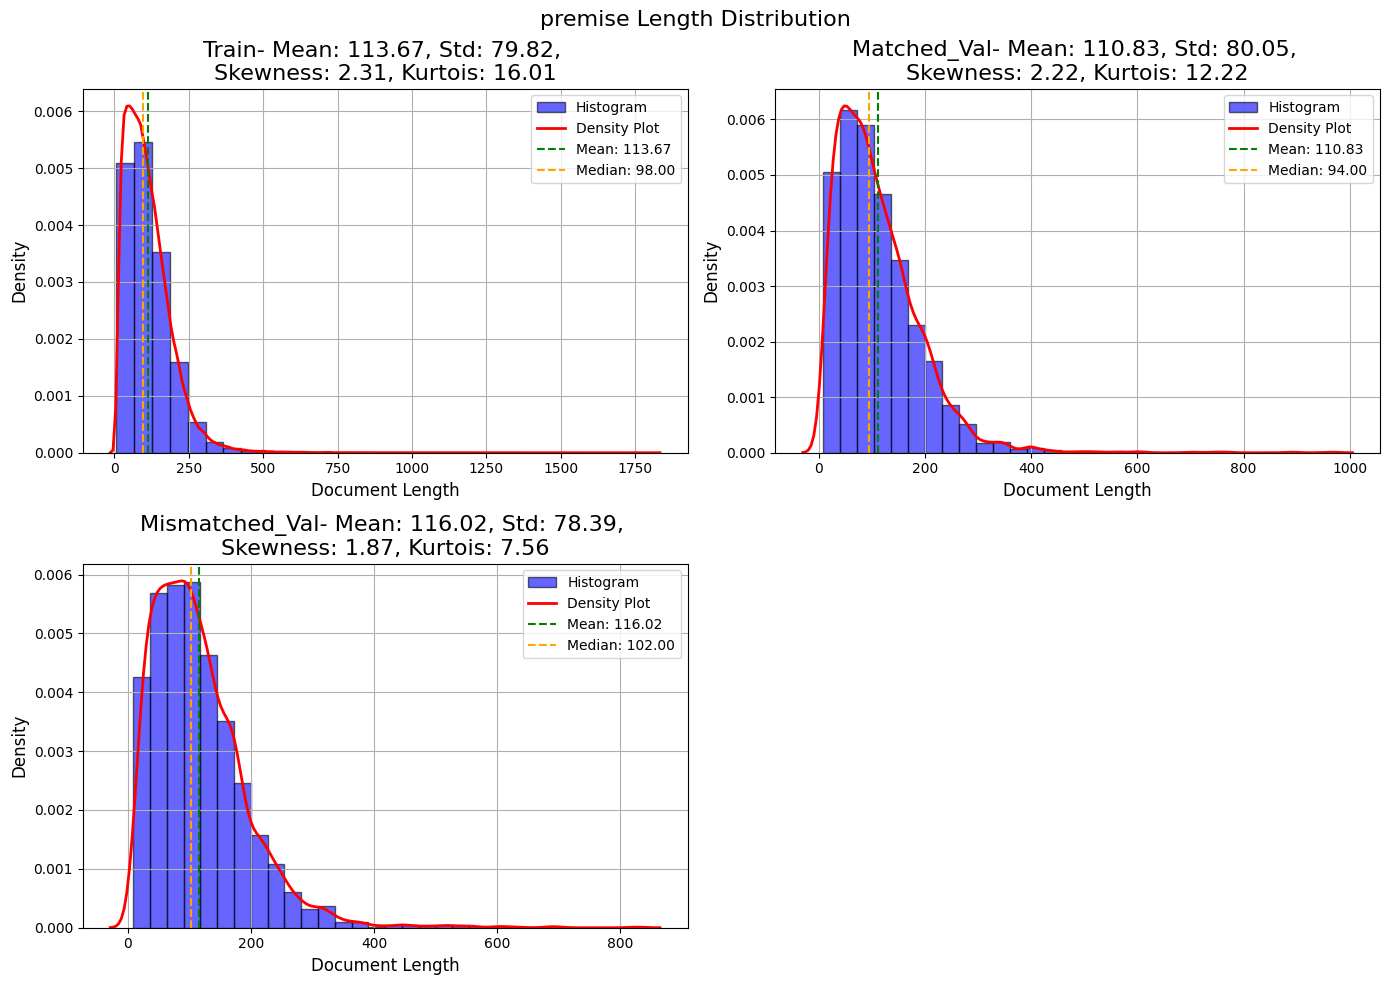

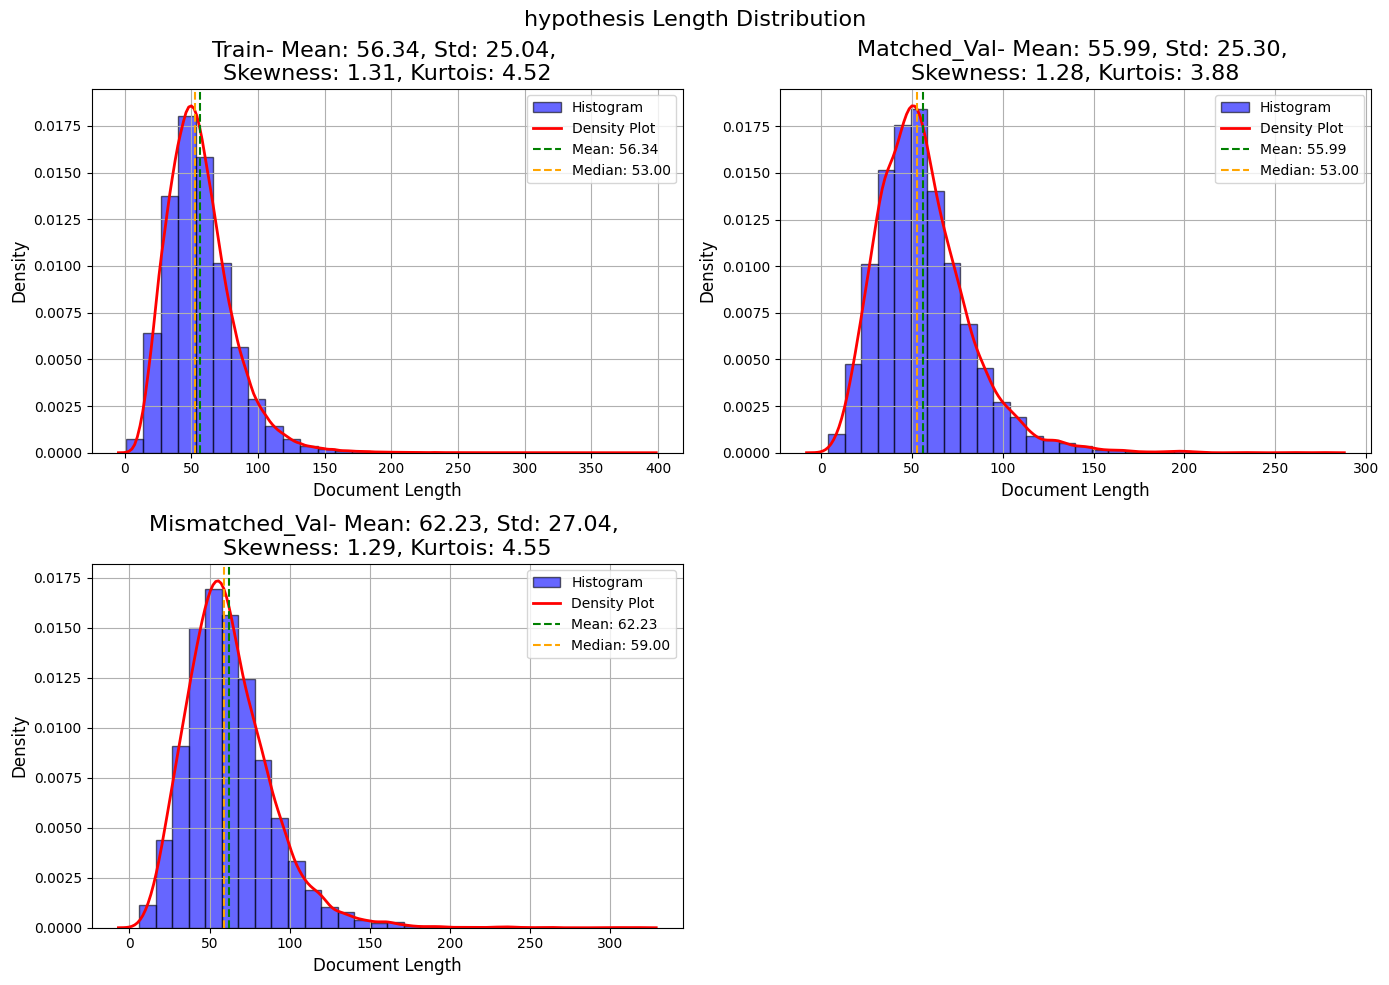

In [8]:
# premise, hypothesis 길이 분포 
# 평균, 표준편차, 왜도, 첨도 계산산
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from scipy.stats import skew, kurtosis

def length_plot(data, name):
    plt.hist(data, bins=30, alpha=0.6, label=f'Histogram', color='blue', edgecolor='black', density=True)
    sns.kdeplot(data, label=f'Density Plot', color='red', linewidth=2)
    
    mean_value = np.mean(data)
    mean_value = np.mean(data)
    std_dev = np.std(data)
    skewness = skew(data)
    kurt = kurtosis(data)
    median_value = np.median(data)

    plt.axvline(mean_value, color='green', linestyle='--', linewidth=1.5, label=f'Mean: {mean_value:.2f}')
    plt.axvline(median_value, color='orange', linestyle='--', linewidth=1.5, label=f'Median: {median_value:.2f}')
    plt.title(f'{name}- Mean: {mean_value:.2f}, Std: {std_dev:.2f}, \nSkewness: {skewness:.2f}, Kurtois: {kurt:.2f}', fontsize=16)
    plt.xlabel('Document Length', fontsize=12)
    plt.ylabel('Density', fontsize=12)
    plt.legend()
    plt.grid(True)

def final_length_plot(length_type):
    plt.figure(figsize=(14,10))

    for i, (df, name) in enumerate(zip([train_df, matched_val_df, mismatched_val_df],['Train', 'Matched_Val', 'Mismatched_Val'])):
        plt.subplot(2,2,i+1)
        length_plot([len(row[length_type]) for _, row in df.iterrows()], name)

    plt.suptitle(f"{length_type} Length Distribution", fontsize=16)
    plt.tight_layout()
    print("\n\n")

final_length_plot('premise')
final_length_plot('hypothesis')
plt.show()


In [17]:
# 모델 config입니다.
model_name = "bert-base-uncased"

test_size = 0.2
random_state = 42
batch_size = 64
max_len_dict = {'max_len_1' : 200, 'max_len_2': 300, 'max_len_3': 400}

results_dir = './results/week3_advanced'
lr = 0.001
n_epochs = 10

### 1.2 [My Code] Preprocess Data

- tokenizer: bert base tokenizer를 사용합니다.

- 데이터셋 구성

    1) train: train_df의 80% / 314129

    2) val: train_df의 20% / 78533

    3) test: matched_val과 mismatched_val_df를 모두 사용합니다 / 9815 - 9832

        - matched_val은 같은 장르 내의 데이터가 학습된 것이기에 mismatched_val_df보다 더 좋은 metric을 보일 것이라 예상합니다.

        - mismatched_val_df는 zeroshot validation이라 할 수 있기에 metric이 더 안나올 것이라 예상할 수 있습니다. 

- tokenize 함수를 이용해 max_len이 200, 300, 400인 데이터셋 3개를 만들었습니다.

In [16]:
from transformers import BertTokenizer

# bert tokenizer를 사용합니다.
# 데이터셋은 imdb 영화 리뷰 데이터입니다.
tokenizer = BertTokenizer.from_pretrained(model_name)

In [28]:
# train, val, test로 데이터 나누기
from sklearn.model_selection import train_test_split 

train_df = train_df[['premise','hypothesis','label']]
test_df = matched_val_df[['premise','hypothesis','label']]
zeroshot_test_df = mismatched_val_df[['premise','hypothesis','label']]

train_df, val_df = train_test_split(train_df, test_size=test_size)

In [41]:
x_train = train_df[['premise','hypothesis']]
y_train = train_df['label']

x_val = val_df[['premise','hypothesis']]
y_val = val_df['label']

x_test = test_df[['premise','hypothesis']]
y_test = test_df['label']

x_test_zeroshot = zeroshot_test_df[['premise','hypothesis']]
y_test_zeroshot = zeroshot_test_df['label']

num = 0

print(f"x_train len: {len(x_train)}")
print(f"y_train len: {len(y_train)}")
print(f"sample train = label : {y_train.iloc[num]}\n text:{x_train.iloc[num]}\n")

print(f"x_val len: {len(x_val)}")
print(f"y_val len: {len(y_val)}")
print(f"sample val= label : {y_val.iloc[num]}\n text:{x_val.iloc[num]}\n")

print(f"x_test shape: {len(x_test)}")
print(f"y_test len: {len(y_test)}\n")
print(f"sample test = label : {y_test.iloc[num]}\n text:{x_test.iloc[num]}\n")

print(f"x_test_zeroshot shape: {len(x_test_zeroshot)}")
print(f"y_test_zeroshot len: {len(y_test_zeroshot)}\n")
print(f"sample test zeroshot = label : {y_test_zeroshot.iloc[num]}\n text:{x_test_zeroshot.iloc[num]}\n")

x_train len: 314129
y_train len: 314129
sample train = label : 0
 text:premise       Democrats called Bush a wolf in sheep's clothing.
hypothesis                   Democrats said Bush was dangerous.
Name: 209823, dtype: object

x_val len: 78533
y_val len: 78533
sample val= label : 2
 text:premise       yeah i've i i graduated back in seventy nine s...
hypothesis         I graduated in 2009, but I was born in 1979.
Name: 53967, dtype: object

x_test shape: 9815
y_test len: 9815

sample test = label : 1
 text:premise                   The new rights are nice enough
hypothesis    Everyone really likes the newest benefits 
Name: 0, dtype: object

x_test_zeroshot shape: 9832
y_test_zeroshot len: 9832

sample test zeroshot = label : 2
 text:premise       Your contribution helped make it possible for ...
hypothesis    Your contributions were of no help with our st...
Name: 0, dtype: object



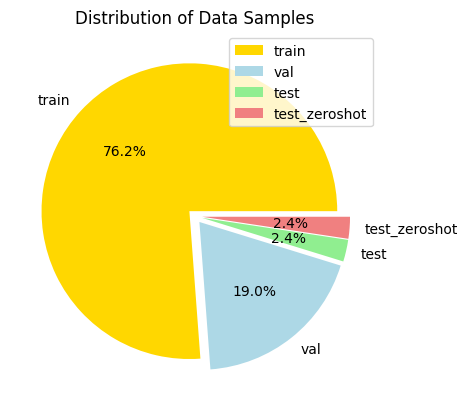

In [45]:
import matplotlib.pyplot as plt

sizes = [len(x_train), len(x_val), len(x_test), len(x_test_zeroshot)]
labels = ['train', 'val', 'test', 'test_zeroshot']
colors = ['gold', 'lightblue', 'lightgreen', 'lightcoral']
explode = [0.05] * len(sizes)  # 각 조각을 0.1만큼 분리

plt.pie(sizes, labels=labels, colors=colors, explode=explode, autopct='%1.1f%%')
plt.title('Distribution of Data Samples')
plt.legend(loc='upper right')
plt.show()

In [48]:
# 허깅페이스 데이터셋 형태로 바꾸기
from datasets import Dataset, DatasetDict
def tokenize(batch, max_len):
  
  return tokenizer(
    batch["premise"], 
    batch['hypothesis'],
    padding="max_length", 
    max_length = max_len, 
    truncation=True, 
    return_tensors = 'pt')


train_data = {
    'premise': x_train['premise'],
    'hypothesis': x_train['hypothesis'],
    "label": y_train,
}

val_data = {
    'premise': x_val['premise'],
    'hypothesis': x_val['hypothesis'],
    "label": y_val,
}

test_data = {
    'premise': x_test['premise'],
    'hypothesis': x_test['hypothesis'],
    "label": y_test,
}

test_data_zeroshot = {
    'premise': x_test_zeroshot['premise'],
    'hypothesis': x_test_zeroshot['hypothesis'],
    "label": y_test_zeroshot,
}

train_dataset = Dataset.from_dict(train_data)
train_dataset = train_dataset.select(range(100))
train_dataset_1 = train_dataset.map(lambda batch: tokenize(batch, max_len_dict['max_len_1']), batched=True)
train_dataset_2 = train_dataset.map(lambda batch: tokenize(batch, max_len_dict['max_len_2']), batched=True)
train_dataset_3 = train_dataset.map(lambda batch: tokenize(batch, max_len_dict['max_len_3']), batched=True)

val_dataset = Dataset.from_dict(val_data)
val_dataset = val_dataset.select(range(100))
val_dataset_1 = val_dataset.map(lambda batch: tokenize(batch, max_len_dict['max_len_1']), batched=True)
val_dataset_2 = val_dataset.map(lambda batch: tokenize(batch, max_len_dict['max_len_2']), batched=True)
val_dataset_3 = val_dataset.map(lambda batch: tokenize(batch, max_len_dict['max_len_3']), batched=True)

test_dataset = Dataset.from_dict(test_data)
test_dataset = test_dataset.select(range(100))
test_dataset_1 = test_dataset.map(lambda batch: tokenize(batch, max_len_dict['max_len_1']), batched=True)
test_dataset_2 = test_dataset.map(lambda batch: tokenize(batch, max_len_dict['max_len_2']), batched=True)
test_dataset_3 = test_dataset.map(lambda batch: tokenize(batch, max_len_dict['max_len_3']), batched=True)

test_dataset_zeroshot = Dataset.from_dict(test_data_zeroshot)
test_dataset_zeroshot = test_dataset_zeroshot.select(range(100))
test_dataset_zeroshot_1 = test_dataset_zeroshot.map(lambda batch: tokenize(batch, max_len_dict['max_len_1']), batched=True)
test_dataset_zeroshot_2 = test_dataset_zeroshot.map(lambda batch: tokenize(batch, max_len_dict['max_len_2']), batched=True)
test_dataset_zeroshot_3 = test_dataset_zeroshot.map(lambda batch: tokenize(batch, max_len_dict['max_len_3']), batched=True)


dataset_dict_1 = DatasetDict(
    {
        "train": train_dataset_1,
        "val": val_dataset_1,
        "test": test_dataset_1,
        "test_data_zeroshot": test_dataset_zeroshot_1
    }
)

dataset_dict_2 = DatasetDict(
    {
        "train": train_dataset_2,
        "val": val_dataset_2,
        "test": test_dataset_2,
        "test_data_zeroshot": test_dataset_zeroshot_2
    }
)

dataset_dict_3 = DatasetDict(
    {
        "train": train_dataset_3,
        "val": val_dataset_3,
        "test": test_dataset_3,
        "test_data_zeroshot": test_dataset_zeroshot_3
    }
)


dataset_dict = DatasetDict(
    {
        "max_len_1" : dataset_dict_1,
        "max_len_2" : dataset_dict_2,
        "max_len_3" : dataset_dict_3,
    }
)

Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Map:   0%|          | 0/100 [00:00<?, ? examples/s]

## 2.[My Code] Model Load

: 허깅페이스의 trainer로 구현을 하는 것이 이번 과제의 추가 목표입니다.

- 모델을 로드합니다. 이 때, num_labels=3로 하면 클래스 3의 다중중 분류기 classifer를 달아줍니다.

- metrics: accuracy와 f1 score

- optimizer: Adamw

- batch_size = 64, 

- lr = 1e-3

### 2.1 [My Code] Max len에 따른 모델

- 모델 2개를 dict에 묶고, key는 max_len_1, max_len_2, max_len_3으로 선언합니다

In [51]:
from transformers import BertForSequenceClassification
from torchinfo import summary

def build_model(freeze=True):
    # 모델 로드
    model = BertForSequenceClassification.from_pretrained(model_name, num_labels=4)

    # 분류기 이전의 모든 파라미터 동결
    if freeze:
        for param in model.bert.parameters():
            param.requires_grad = False
    return model

model_dict = {
    'max_len_1-freeze' : build_model(freeze=True),
    'max_len_2-freeze' : build_model(freeze=True),
    'max_len_3-freeze' : build_model(freeze=True),
}

# 모델 정보 출력
for max_len_type in model_dict.keys():
    print(f"Model Summary: {max_len_type}")
    print(summary(model_dict[max_len_type], input_size=(batch_size, max_len_dict[max_len_type.split('-')[0]]), dtypes=[torch.int64]))
    print("\n\n")

    

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model Summary: max_len_1-freeze


We strongly recommend passing in an `attention_mask` since your input_ids may be padded. See https://huggingface.co/docs/transformers/troubleshooting#incorrect-output-when-padding-tokens-arent-masked.


Layer (type:depth-idx)                                       Output Shape              Param #
BertForSequenceClassification                                [64, 4]                   --
├─BertModel: 1-1                                             [64, 768]                 --
│    └─BertEmbeddings: 2-1                                   [64, 200, 768]            --
│    │    └─Embedding: 3-1                                   [64, 200, 768]            (23,440,896)
│    │    └─Embedding: 3-2                                   [64, 200, 768]            (1,536)
│    │    └─Embedding: 3-3                                   [1, 200, 768]             (393,216)
│    │    └─LayerNorm: 3-4                                   [64, 200, 768]            (1,536)
│    │    └─Dropout: 3-5                                     [64, 200, 768]            --
│    └─BertEncoder: 2-2                                      [64, 200, 768]            --
│    │    └─ModuleList: 3-6                                  --     

## 3.[My Code] Training

- huggingface trainer를 사용하여 훈련을 진행합니다.

- 확실히 naive torch 버전으로 모델을 훈련시키는 것보다 코드가 간편해지는 것을 확인할 수 있습니다.

In [52]:
from transformers import TrainingArguments, Trainer
from sklearn.metrics import accuracy_score, f1_score
# compute metrics은 반드시 아래와 같이 dict의 형태로 나와야 한다.
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    acc = accuracy_score(labels, predictions)
    f1 = f1_score(labels, predictions, average='weighted')
    return {'accuracy': acc, 'f1': f1}

training_args = TrainingArguments(
    output_dir=results_dir, 
    num_train_epochs=n_epochs,  
    eval_strategy="epoch",
    save_strategy="epoch",
    logging_strategy="epoch",
    logging_dir=results_dir,  
    per_device_train_batch_size=batch_size, 
    per_device_eval_batch_size=batch_size,  
)

In [53]:
def build_triner(max_len_type, training_args):
    trainer = Trainer(
        model=model_dict[max_len_type],
        args=training_args,
        train_dataset=dataset_dict[max_len_type.split('-')[0]]["train"],
        eval_dataset=dataset_dict[max_len_type.split('-')[0]]["val"],
        compute_metrics=compute_metrics,
    )

    return trainer

trainer_dict = {
    'max_len_1-freeze' : build_triner('max_len_1-freeze', training_args),
    'max_len_2-freeze' : build_triner('max_len_2-freeze', training_args),
    'max_len_3-freeze' : build_triner('max_len_2-freeze', training_args),
}

In [54]:
trainer_dict['max_len_1-freeze'].train()

wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: khk172216. Use `wandb login --relogin` to force relogin


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,1.593600,1.598046,0.350000,0.181481
2,1.564900,1.560844,0.350000,0.181481
3,1.508500,1.528986,0.350000,0.181481
4,1.465300,1.502735,0.350000,0.181481
5,1.507100,1.481319,0.350000,0.181481
6,1.470900,1.463818,0.350000,0.181481
7,1.458900,1.450237,0.350000,0.181481
8,1.456800,1.440407,0.350000,0.181481
9,1.388900,1.434170,0.350000,0.181481
10,1.364600,1.431514,0.350000,0.181481


TrainOutput(global_step=20, training_loss=1.477953350543976, metrics={'train_runtime': 24.2654, 'train_samples_per_second': 41.211, 'train_steps_per_second': 0.824, 'total_flos': 102779601600000.0, 'train_loss': 1.477953350543976, 'epoch': 10.0})

In [55]:
trainer_dict['max_len_2-freeze'].train()

Epoch,Training Loss,Validation Loss,Accuracy,F1
1,1.887400,1.822085,0.000000,0.000000
2,1.808200,1.764893,0.000000,0.000000
3,1.728300,1.717002,0.000000,0.000000
4,1.656500,1.677707,0.000000,0.000000
5,1.647000,1.646243,0.000000,0.000000
6,1.596400,1.621247,0.000000,0.000000
7,1.584200,1.602242,0.000000,0.000000
8,1.599300,1.588689,0.000000,0.000000
9,1.580200,1.580163,0.000000,0.000000
10,1.590600,1.576534,0.000000,0.000000


TrainOutput(global_step=20, training_loss=1.6677974820137025, metrics={'train_runtime': 28.8418, 'train_samples_per_second': 34.672, 'train_steps_per_second': 0.693, 'total_flos': 154169402400000.0, 'train_loss': 1.6677974820137025, 'epoch': 10.0})

In [56]:
trainer_dict['max_len_3-freeze'].train()

Epoch,Training Loss,Validation Loss,Accuracy,F1
1,1.590300,1.530454,0.000000,0.000000
2,1.521600,1.493957,0.010000,0.019444
3,1.504900,1.463506,0.130000,0.136881
4,1.426900,1.438902,0.290000,0.199741
5,1.396700,1.419742,0.310000,0.217500
6,1.410300,1.404554,0.320000,0.221983
7,1.387500,1.393089,0.310000,0.216368
8,1.400600,1.384951,0.310000,0.216368
9,1.368500,1.379807,0.310000,0.216368
10,1.411900,1.377617,0.310000,0.216368


TrainOutput(global_step=20, training_loss=1.4419201016426086, metrics={'train_runtime': 29.44, 'train_samples_per_second': 33.967, 'train_steps_per_second': 0.679, 'total_flos': 154169402400000.0, 'train_loss': 1.4419201016426086, 'epoch': 10.0})

## 4.[My Code] Metric Plotting

In [67]:
# 테스트 데이터셋에 대한 예측 및 평가
def cal_metrics(max_len_type):
    test_results = trainer_dict[max_len_type].predict(test_dataset=dataset_dict[max_len_type.split('-')[0]]["test"])
    metrics = test_results.metrics
    test_results_zeroshot = trainer_dict[max_len_type].predict(test_dataset=dataset_dict[max_len_type.split('-')[0]]["test_data_zeroshot"])
    metrics_zeroshot = test_results_zeroshot.metrics
    print(f"Test {max_len_type} Metrics:", "\n", "loss: ", metrics['test_loss'], "accuracy: ", metrics['test_accuracy'], "f1:", metrics['test_f1'])
    print(f"Test {max_len_type} Zeroshot Metrics:", "\n", "loss: ", metrics_zeroshot['test_loss'], "accuracy: ", metrics_zeroshot['test_accuracy'], "f1:", metrics_zeroshot['test_f1'])
    return {'test': metrics, 'test_data_zeroshot': metrics_zeroshot}

metrics_dict = {
    'max_len_1-freeze': cal_metrics('max_len_1-freeze'),
    'max_len_2-freeze': cal_metrics('max_len_2-freeze'),
    'max_len_3-freeze': cal_metrics('max_len_3-freeze'),
    }

Test max_len_1-freeze Metrics: 
 loss:  1.4027340412139893 accuracy:  0.33 f1: 0.17
Test max_len_1-freeze Zeroshot Metrics: 
 loss:  1.287124514579773 accuracy:  0.43 f1: 0.2695877659574468


Test max_len_2-freeze Metrics: 
 loss:  1.4280627965927124 accuracy:  0.34 f1: 0.21883720930232556
Test max_len_2-freeze Zeroshot Metrics: 
 loss:  1.3987208604812622 accuracy:  0.37 f1: 0.30349264705882356


Test max_len_3-freeze Metrics: 
 loss:  1.4280627965927124 accuracy:  0.34 f1: 0.21883720930232556
Test max_len_3-freeze Zeroshot Metrics: 
 loss:  1.3987208604812622 accuracy:  0.37 f1: 0.30349264705882356


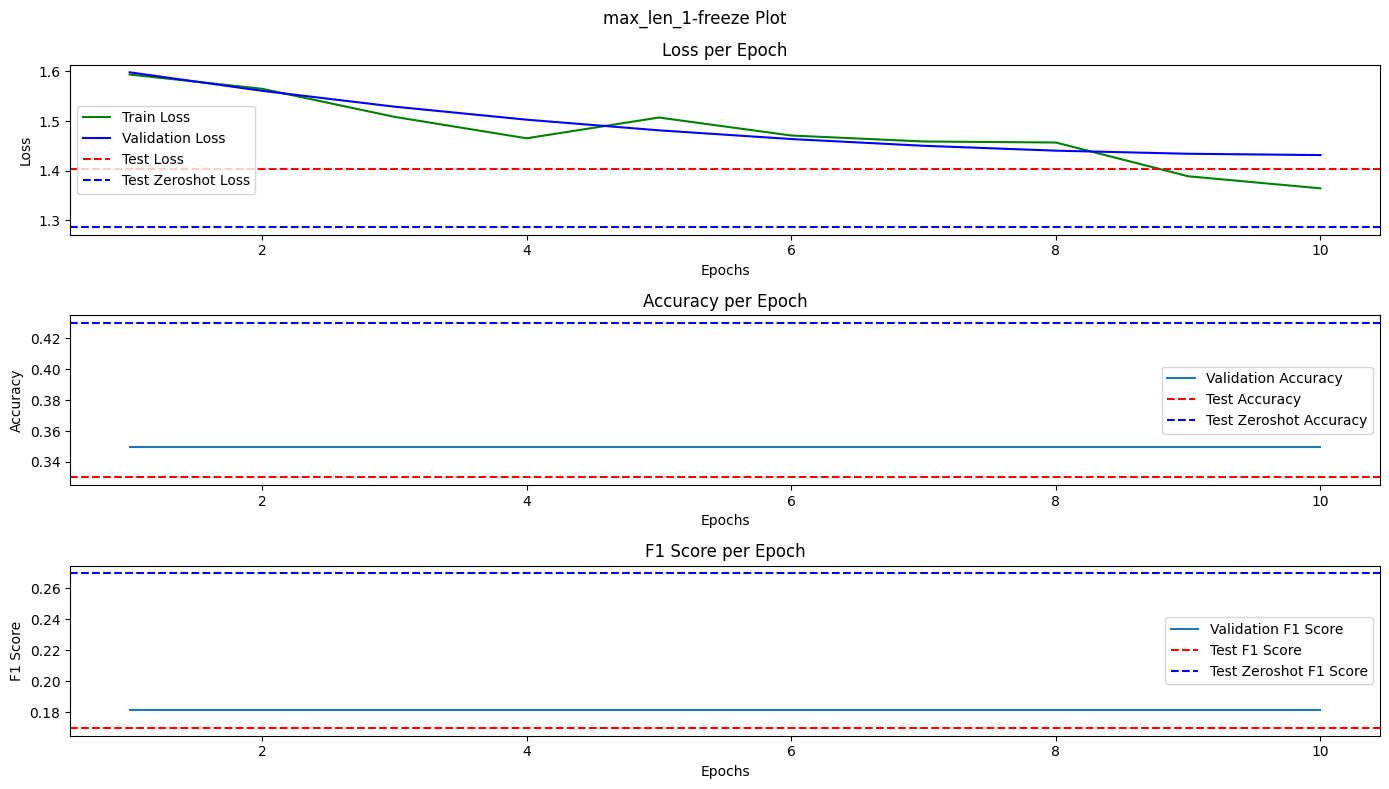

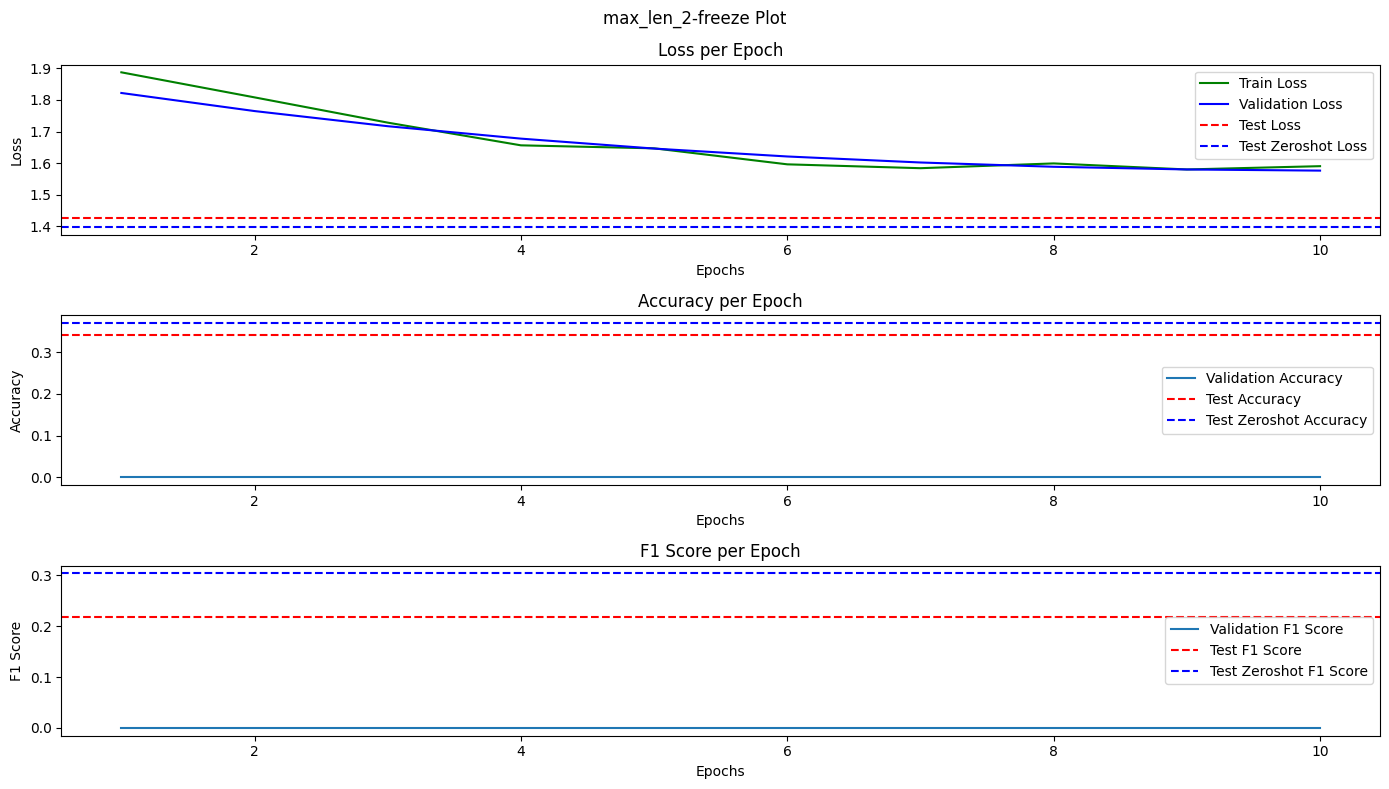

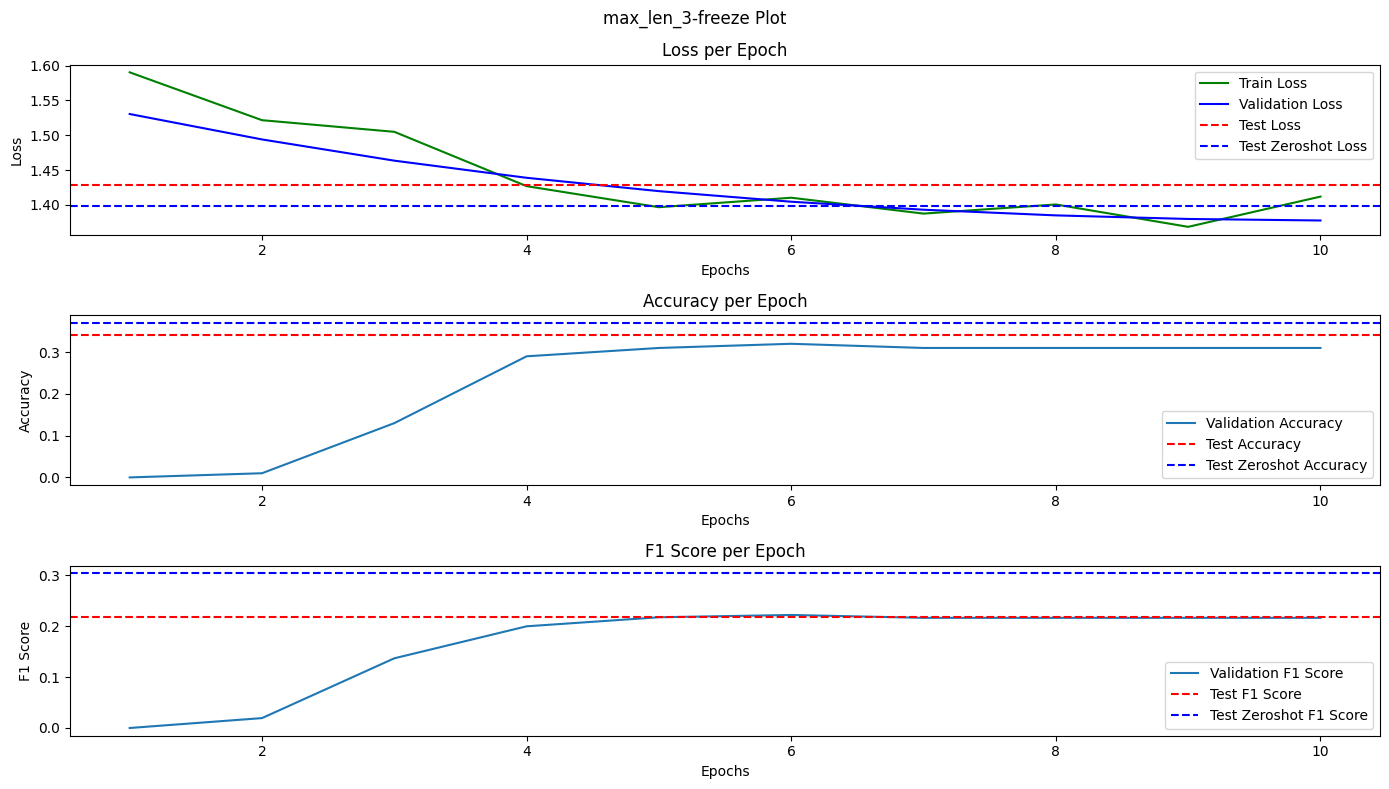

In [70]:
import matplotlib.pyplot as plt

def plotting(max_len_type):
    # 로그 데이터 추출
    log_history = trainer_dict[max_len_type].state.log_history

    # 메트릭 초기화
    epochs = []
    train_loss = []
    val_loss = []
    val_accuracy = []
    val_f1 = []

    # 로그 데이터 분리
    for log in log_history:
        if 'epoch' in log:
            current_epoch = log['epoch']
            if current_epoch not in epochs:
                epochs.append(current_epoch)
            if 'loss' in log:
                train_loss.append(log['loss'])
            if 'eval_loss' in log:
                val_loss.append(log['eval_loss'])
            if 'eval_accuracy' in log:
                val_accuracy.append(log['eval_accuracy'])
            if 'eval_f1' in log:
                val_f1.append(log['eval_f1'])

    test_loss = metrics_dict[max_len_type]['test']['test_loss']
    test_accuracy = metrics_dict[max_len_type]['test']['test_accuracy']
    test_f1 = metrics_dict[max_len_type]['test']['test_f1']

    test_loss_zeroshot = metrics_dict[max_len_type]['test_data_zeroshot']['test_loss']
    test_accuracy_zeroshot = metrics_dict[max_len_type]['test_data_zeroshot']['test_accuracy']
    test_f1_zeroshot = metrics_dict[max_len_type]['test_data_zeroshot']['test_f1']

    # 플로팅
    plt.figure(figsize=(14, 8))

    # 손실 플롯
    plt.subplot(3, 1, 1)
    plt.plot(epochs, train_loss, color = 'g', label='Train Loss')
    plt.plot(epochs, val_loss, color = 'b', label='Validation Loss')
    plt.axhline(y=test_loss, color='r', linestyle='--', label='Test Loss')
    plt.axhline(y=test_loss_zeroshot, color='blue', linestyle='--', label='Test Zeroshot Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Loss per Epoch')
    plt.legend()

    # 정확도 및 F1 스코어 플롯
    plt.subplot(3, 1, 2)
    plt.plot(epochs, val_accuracy, label='Validation Accuracy')
    plt.axhline(y=test_accuracy, color='r', linestyle='--', label='Test Accuracy')
    plt.axhline(y=test_accuracy_zeroshot, color='blue', linestyle='--', label='Test Zeroshot Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Accuracy per Epoch')
    plt.legend()

    plt.subplot(3, 1, 3)
    plt.plot(epochs, val_f1, label='Validation F1 Score')
    plt.axhline(y=test_f1, color='r', linestyle='--', label='Test F1 Score')
    plt.axhline(y=test_f1_zeroshot, color='blue', linestyle='--', label='Test Zeroshot F1 Score')
    plt.xlabel('Epochs')
    plt.ylabel('F1 Score')
    plt.title('F1 Score per Epoch')
    plt.legend()

    plt.suptitle(f"{max_len_type} Plot")
    plt.tight_layout()
    print("\n\n")

plotting('max_len_1-freeze')
plotting('max_len_2-freeze')
plotting('max_len_3-freeze')
plt.show()

In [89]:
import pandas as pd

def count_trainable_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

# 학습 가능한 파라미터 수 출력
trainable_params_lst = [count_trainable_parameters(model_dict[name]) for name in metrics_dict.keys()]
train_runtime_lst = [trainer_dict[name].state.log_history[-1]['train_runtime'] for name in  metrics_dict.keys()]

result_df = pd.DataFrame([metrics_dict[name]['test'] for name in  metrics_dict.keys()])
result_df.index = metrics_dict.keys()
result_df['trainable_parameters']  = trainable_params_lst
result_df['train_runtime'] = train_runtime_lst
display(result_df[['test_loss','test_accuracy','test_f1','trainable_parameters', 'train_runtime', 'test_runtime']])

result_df_zeroshot = pd.DataFrame([metrics_dict[name]['test_data_zeroshot'] for name in  metrics_dict.keys()])
result_df_zeroshot.index = metrics_dict.keys()
result_df_zeroshot['trainable_parameters']  = trainable_params_lst
result_df_zeroshot['train_runtime'] = train_runtime_lst
result_df_zeroshot = result_df_zeroshot.rename(columns = {'test_loss':'test_zeroshot_loss', 'test_accuracy':'test_zeroshot_accuracy','test_f1':'test_zeroshot_f1'})
display(result_df_zeroshot[['test_zeroshot_loss','test_zeroshot_accuracy','test_zeroshot_f1','trainable_parameters', 'train_runtime', 'test_runtime']])

,test_loss,test_accuracy,test_f1,trainable_parameters,train_runtime,test_runtime
max_len_1-freeze,1.402734,0.33,0.170000,3076,24.2654,1.0499
max_len_2-freeze,1.428063,0.34,0.218837,3076,28.8418,1.1043
max_len_3-freeze,1.428063,0.34,0.218837,3076,29.4400,1.5933


,test_zeroshot_loss,test_zeroshot_accuracy,test_zeroshot_f1,trainable_parameters,train_runtime,test_runtime
max_len_1-freeze,1.287125,0.43,0.269588,3076,24.2654,0.7255
max_len_2-freeze,1.398721,0.37,0.303493,3076,28.8418,1.1187
max_len_3-freeze,1.398721,0.37,0.303493,3076,29.4400,1.5924


## 5. [My Code] Conclusion